# Project Zillow

## Goal: 
* Find the key drivers of property value for single family properties.
* Make a regression model that predicts assessed worth of Single Family Properties using data from 2017.

---

## <div class="alert alert-block alert-info"> Imports<div>

In [1]:
# My Modules
import wrangle as wr
import explore as ex
import stats_conclude as sc
import evaluate as ev

# Imports
import os

# Numbers
import pandas as pd 
import numpy as np
import scipy.stats as stats

# Vizzes
import matplotlib.pyplot as plt
import seaborn as sns

# Splitting
from sklearn.model_selection import train_test_split

# Engineering
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_selection import RFE

# Modeling
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

import warnings
warnings.filterwarnings("ignore")

Load in successful, awaiting commands...


## <div class="alert alert-block alert-info"> Wrangle
      
### Acquire
* Data acquired from mySQL Codeup Server using env.py credentials
* It contained 52,442 rows and 7 columns before cleaning/encoding
* Each row represents a property
* Each column represents a feature
  
### Prepare
* Checked column data types
    * Deatils in code
* Checked for duplicates 
    * 122 duplicates found in parcelid
        * deleted duplicate occurences, kept last value because it makes sense that you can sell a home more than once in one year. The last sell likely has the most recent assessed worth.
* Checked for nulls
    * Sqft: 82
    * Assessed Worth: 1
    * AC: 38,705 (76% of AC data... dropped, not enough data to interpret without severe manipulation)
* Split data into train, validate and test (60/20/20)
    * target = 'assessed worth'
* Outliers have been removed for this iteration of the project using IQR ranges:
    * Details in code
    
### Data Dictionary
* Explanation of dataset features
 

| Feature | Definition |
|:--------|:-----------|
|Bed| The number of bedrooms|
|Bath| The number of bathrooms|
|Sqft| The square feet of the property|
|Assessed Worth| **target** This is the assessed worth of the home|
|County| This is the location of the property, (LA, Orange, Venutra)|
|Date| This is the transaction date|

In [2]:
# Acquire
df = wr.get_zillow()

CSV file found and loaded


In [3]:
# Prepare: cleaning data
df_clean = wr.wrangle_zillow(df)

Prepare Details
--------------------------------------------
Renamed columns for ease of use
Nulls removed: Percent Original Data Remaining: 100.0
Bed datatype changed from float to integer
Changed FIPS code to actual county name
--------------------------------------------
County is a categorical column.
Date is a categorical column.
--------------------------------------------
Outliers Calculated with IQR Ranges, multiplier 1.5
Bed < = 5.5 and > 1.5
Bath < = 4.5 and > 0.5
Sqft < = 3640.0 and > -160.0
Assessed worth < = 1135281.5 and > -386956.5
Outliers removed: Percent Original Data Remaining: 88.0


In [4]:
# Prepare: SPLIT
train, validate, test = wr.split_zillow(df_clean)

Prepared DF: (45902, 6)
Train: (27540, 6)
Validate: (9181, 6)
Test: (9181, 6)


<div class="alert alert-block alert-info"> 
    
## Explore
    
### Questions To Answer:
1. What is more important for property value, bathrooms or bedrooms?
2. Does sqft affect value?
3. Does having A/C affect property value?
    * During exploration of the data, the AC column had over 38,000 nulls. I couldn't properly impute the data without manipulating the data an egregious amount.
    * The AC column was dropped.
4. Does County affect worth?
   

## <div class="alert alert-block alert-info">  1. What is more important for worth: bathrooms or bedrooms?

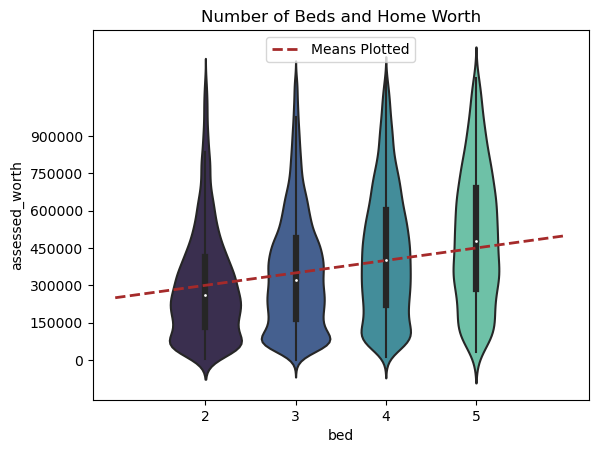

In [5]:
# visualize
ex.plot_bed(train, 'bed')

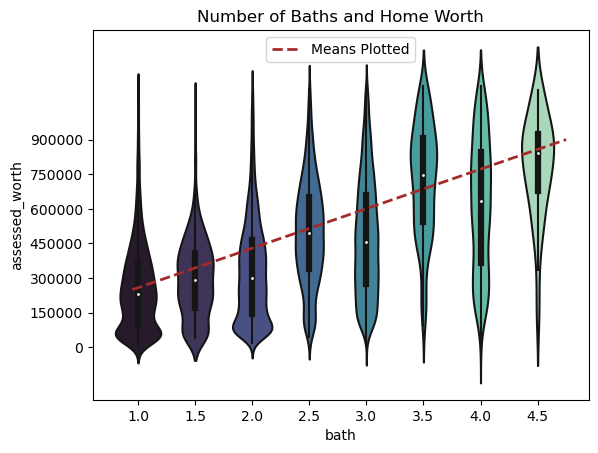

In [6]:
ex.plot_bath(train, 'bath')

<div class="alert alert-block alert-info"> 

According to the violinplot, bedroom means are linearly related. 
    
The violinplot shows at the 2-2.5, 3-3.5, and 4-4.5 bath ranges that the means jump significantly.

### Anaylze 

$H_0$: The mean of bedrooms/bathrooms is <= to the $\mu$ of assessed worth

$H_a$: The mean of bedrooms/bathroom is > to the $\mu$ of assessed worth

In [7]:
# Using one sample, left-tailed t-test with assumptions met
sc.conclude_1samp_lt(train.bed, train.assessed_worth.mean())

Assumptions are met: One-Sample, Left-Tailed T-Test successful...
t-stat: -78406690.18333378 < 0?
p-value: 0.0 < 0.05?

----
We can reject the null hypothesis.


In [8]:
# Using one sample, left-tailed, t-test with assumptions met
sc.conclude_1samp_lt(train.bath, train.assessed_worth.mean())

Assumptions are met: One-Sample, Left-Tailed T-Test successful...
t-stat: -84007036.75660767 < 0?
p-value: 0.0 < 0.05?

----
We can reject the null hypothesis.


<div class="alert alert-block alert-info">
      
This demonstrates that the cheaper a home is, the more bedrooms and bathrooms play a role in the worth.
 

## 2. Does Sqft affect worth?

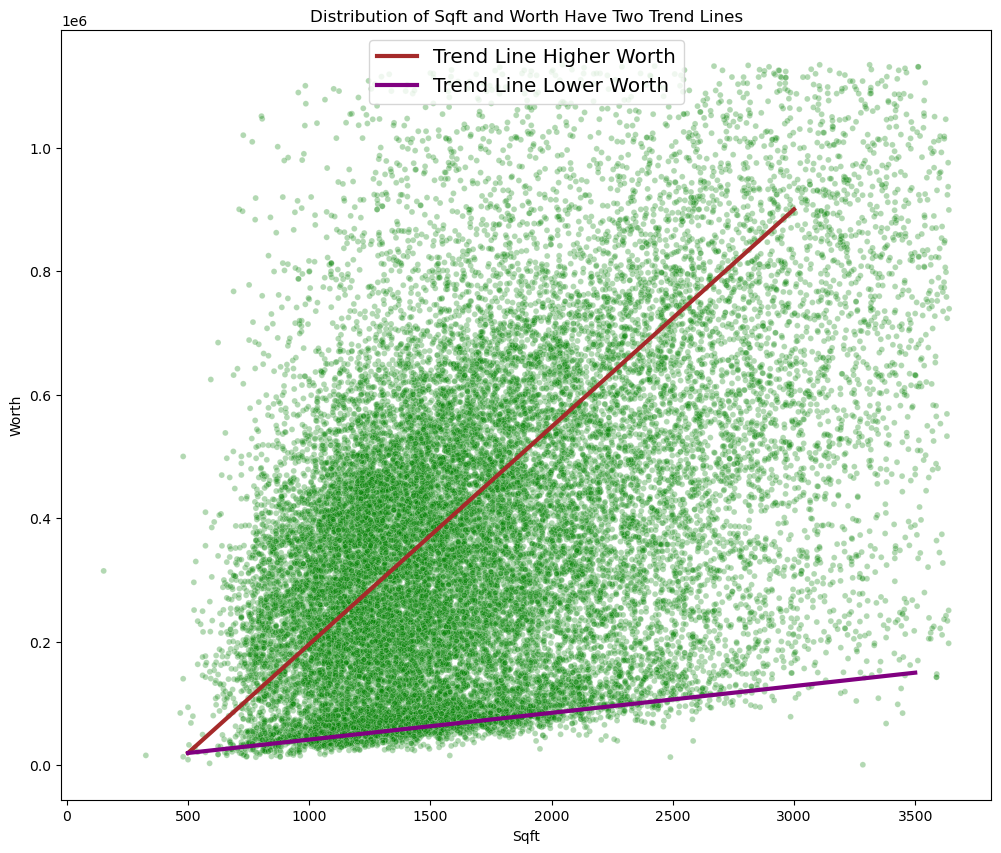

In [9]:
# visualize
ex.plot_sqft(train)

<div class="alert alert-block alert-info">
There are two clear relationships with sqft and worth as displayed in the graph.
    
* Did not run stats tests to confirm in final report. Additional exploration in the exlore notebook.
    
    * **INTERESTING NOTE:**
        * Bed, Bath, and Sqft all rejected the null on the left-tailed test but failed to reject on the right-tailed test, proving exactly what we see here visually.
    
---

* If a home is worth *greater than* ~$180,000; sqft matters *less.*
    
* If a home is worth *less than* ~$180,000; sqft matters *more.*
   

## 3. Does having A/C affect worth?

#### 38,000+ Nulls, dropped the column, not of value in its current state

## 4. Does County affect worth?

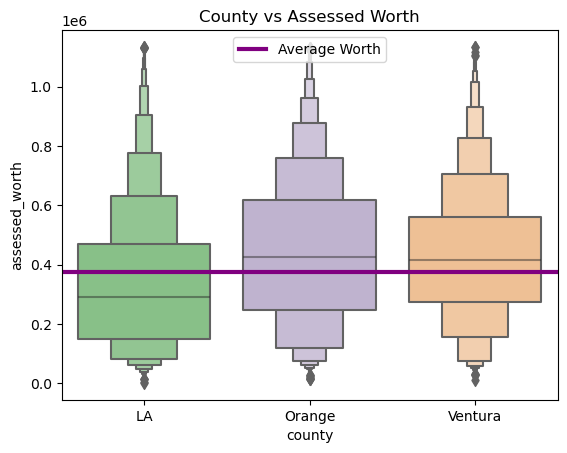

In [10]:
# county visualization
ex.plot_county(train)

<div class="alert alert-block alert-info">  

County clearly impacts the worth of a home:
    
* Stats confirmation in explore notebook.
    
* The mean worth for LA is far lower than Orange and Ventura county even though it has the highest proportion of values. 
* Ventura, having only 9% of the proportion is almost equal to Orange County's mean home worth.
    
---
    
This information supports the hypothesis that we are missing a feature related to location.

<div class="alert alert-block alert-info">  

### Explore Takeaways:

**Target = Assessed Worth**

There is a feature that is not in this dataset that likely contributes greater to a house's worth. It may have to be engineered from existing features that are correlated.
    
In this first iteration, we will proceed to modeling with these features:

#### Features to Send In:
    
* Bed
* Bath
* Sqft
* Counties
    
#### Features to Exclude:
* Excluded Date because it needs some engineering to make it applicable, next steps...
    
---
    
The cheaper the house, the more important bedrooms, bathrooms, and sqft are. 
    
While the homes climb in price, these features become less important. Something else is affecting worth for the higher valued homes...
<div> 

<div class="alert alert-block alert-info"> 

## Preprocessing

* Encode any categoricals

* Engineered Features:
    * None for this iteration
  
* Scale into train, validate, test    
* Split into X_train, y_train, X_validate, y_validate, X_test, y_test


In [11]:
# Encode
df_encoded = ex.encode_zillow(df_clean)

Encoded County column and renamed encoded columns for readability
DataFrame is encoded and ready for modeling. :)


In [12]:
# Split
train_e, validate_e, test_e, = wr.split_zillow(df_encoded)

Prepared DF: (45902, 6)
Train: (27540, 6)
Validate: (9181, 6)
Test: (9181, 6)


In [13]:
# Assign
X_train, y_train, X_validate, y_validate, X_test, y_test = \
wr.x_y_train_validate_test(train_e, validate_e, test_e, 'assessed_worth')

Variable assignment successful...
Verifying number of features and target:
Train: ((27540, 5), (27540, 1))
Validate: ((9181, 5), (9181, 1))
Test: ((9181, 5), (9181, 1))


In [14]:
# Scale
to_scale = X_train.columns.tolist()

X_train_scaled, X_validate_scaled, X_test_scaled = wr.scale_data(X_train, X_validate, X_test, to_scale)

<div class="alert alert-block alert-info"> 
    
## Models to Run:
    
* OLS (Linear Regression)
* LassoLars
* GLM (Generalized Linear Model)
* Polynomial Regression (Degree of X)
 
---
    
#### RMSE and R2 are the evaluation metrics   
    
#### Focus is to accurately predict property value for this iteration.

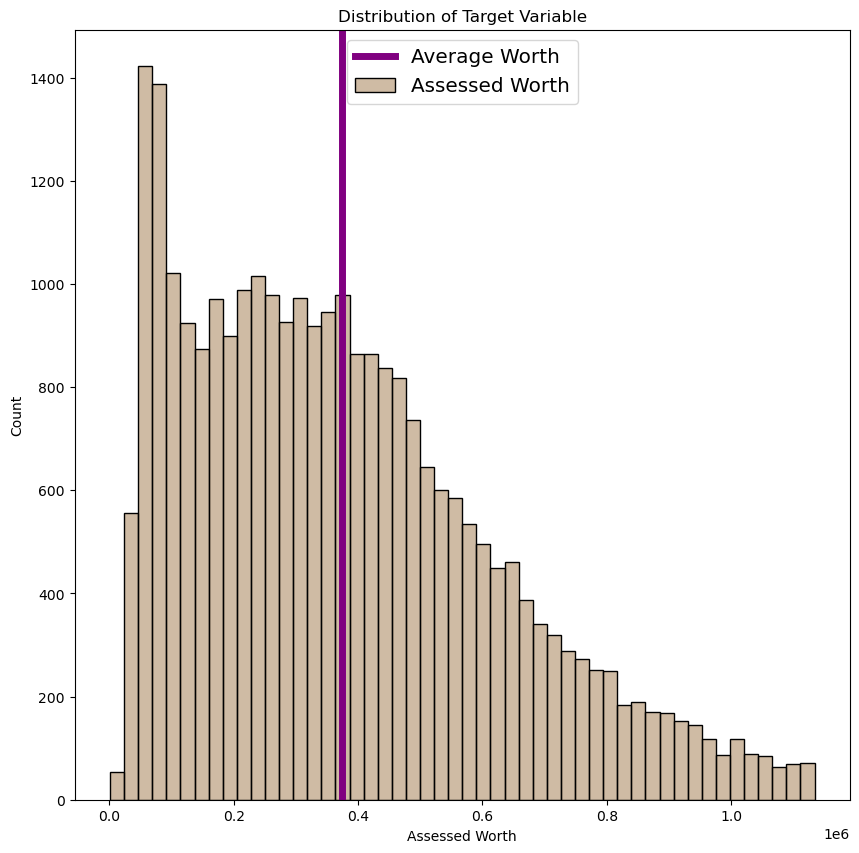

In [15]:
ex.plot_target(y_train)

In [16]:
# calculating SSE & SSE_baseline values and results of test 
SSE, SSE_baseline, metrics_df = ev.baseline_test(X_train_scaled, y_train, X_test_scaled, y_test)

In [17]:
# compare results to baseline, true if better
ev.better_than_baseline(SSE, SSE_baseline)

True

In [19]:
# beat baseline
metrics_df

,Model,RMSE,R2
0,Baseline,246078.469289,1.110223e-16
1,POLY_2,215280.877803,2.622933e-01


<div class="alert alert-block alert-info">
    
## Modeling Conclusion:
    
* Target variable is binomial
* Used a Polynomial Regression with a degree of 2
* Beat baseline!

<div class="alert alert-block alert-info">
    
# Project Conclusion
    

### Explore:
    
* Cleaned the data, keeping 88% of the original dataset.
    
* There are 2 clear relationships with sqft and worth.
    
    
* Overall, bed, bath, and sqft rejected the null for the left-tailed test. This matches what we saw visually. The less a home is worth, the more these features seem to matter.
   
* Something else affects the worth in a greater way and it's related to Counties, possibly, a *mountain range? ...*
    
### Modeling:
    
* Baseline RMSE = $246,079 of error<br>
    
* Poly RMSE = $215,281 of error<br>
    
* Baseline R2 = .111<br>
* Poly R2 = .262<br>
    
### Recommendations and Next Steps:
 
* For the data engineers: Engineer Location Features to improve predicatability of the model
* For the data scientsists: Check for multicollinearity among the predictor variables and remove any highly correlated variables, replacing with new features
* For the business: Improvements in features will increase performance and lead to better results
